<a href="https://colab.research.google.com/github/WenxuanDU/ECON441B/blob/main/Week_7_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [49]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("FSLR", start="2007-01-01", end="2022-02-21")


# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [51]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5 ## ?
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])## if y_train >0 :1
                                    ## elif y_train <0 :0
### binary forecast did the stock price move up or down tmr
### y train not percentage diff
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25,activation="relu"))
model.add(Dense(32,activation="sigmoid"))
#Examples
#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(25))
## change classification algo using cheat sheet



model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
3043/3043 [==============================] - 33s 9ms/step - loss: 0.0052
Epoch 2/3
3043/3043 [==============================] - 18s 6ms/step - loss: 0.0016
Epoch 3/3
3043/3043 [==============================] - 19s 6ms/step - loss: 0.0016


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [52]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [54]:
y_train_reshaped=y_train.reshape(3043,1)
y_train_reshaped.shape

(3043, 1)

In [55]:
#Random Walk
in_sample_rw_y_true=y_train[1:] #Actual
in_sample_rw_y_pred=y_train[:-1] #Prediction

out_of_sample_rw_y_true=y_test[1:] #Actual
out_of_sample_rw_y_pred=y_test[:-1] #Prediction
#In-sample RW RMSE
in_sample_rw_rmse=np.sqrt(np.mean(in_sample_rw_y_pred-in_sample_rw_y_true)**2)
print('In sample RW RMSE:',in_sample_rw_rmse)
#Out-of-sample RW RMSE
out_of_sample_rw_rmse=np.sqrt(np.mean(out_of_sample_rw_y_pred-out_of_sample_rw_y_true)**2)
print('Out of sample RW RMSE:',out_of_sample_rw_rmse)
#In-sample RMSE
y_train_pred=model.predict(x_train)
in_sample_rmse=np.sqrt(np.mean(y_train_pred - y_train_reshaped)**2)
print('In sample RMSE:',in_sample_rmse)
#Out-of-sample RMSE
y_test_pred=model.predict(x_test)
out_of_sample_rmse=np.sqrt(np.mean(y_test_pred - y_test)**2)
print('Out of sample RMSE:',out_of_sample_rmse)

In sample RW RMSE: 1.5410624637460262e-06
Out of sample RW RMSE: 3.585945460368551e-05
96/96 [==============================] - 4s 9ms/step
In sample RMSE: 0.0008549229965203296
24/24 [==============================] - 0s 8ms/step
Out of sample RMSE: 0.0007695580131772121


In [56]:
y_train_pred.shape

(3043, 32)

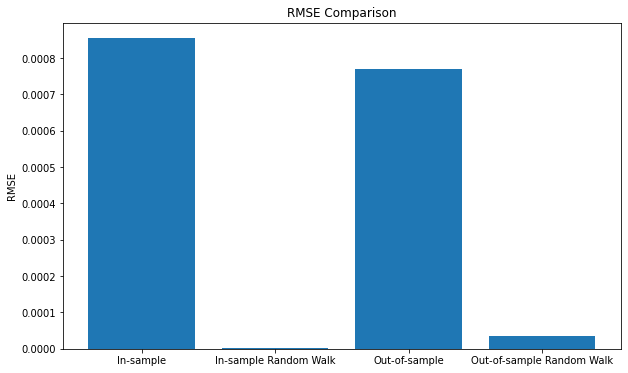

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
rmse = [in_sample_rmse, in_sample_rw_rmse,
              out_of_sample_rmse, out_of_sample_rw_rmse]
labels = ['In-sample', 'In-sample Random Walk', 'Out-of-sample', 'Out-of-sample Random Walk']

plt.bar(labels, rmse)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

dont do# 4.) Plot in and out of sample accuracy

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

RMSE result is much larger than random walk result. The RMSE of in-sample data is also larger than that of out-of-sample data.